# Word analysis

Experimental analysis for removing "bad" clues from `ClueProcessor`.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import generation.constants as const
from generation.clue_processor import CollectiveClueProcessor

for source in const.CLUE_SOURCES:
    source['path'] = os.path.join(const.DATA_PATH, source['file_name'])
clue_processor = CollectiveClueProcessor(const.CLUE_SOURCES)

all_words = []
for v in clue_processor.words.values():
    all_words.extend(list(v['all']))
all_words

Processing: c:\Users\prest\Documents\Github\crossword-generator\crossword_generator\generation\..\data\xd-cleaned.txt
Done processing clues
Done processing words
Processing: c:\Users\prest\Documents\Github\crossword-generator\crossword_generator\generation\..\data\ginsberg-clues-cleaned.txt
Done processing clues
Done processing words
Processing: c:\Users\prest\Documents\Github\crossword-generator\crossword_generator\generation\..\data\ginsberg-puns-cleaned.csv
Done processing clues
Done processing words
Processing: c:\Users\prest\Documents\Github\crossword-generator\crossword_generator\generation\..\data\scraped-clues-xwordinfo-cleaned.csv
Done processing clues
Done processing words


['EEO',
 'WEE',
 'WSJ',
 'JOG',
 'BTY',
 'FOP',
 'ISL',
 'FIL',
 'LAM',
 'CYM',
 'RIB',
 'LDR',
 'RGS',
 'BTE',
 'EPS',
 'BSN',
 'SYD',
 'STN',
 'COW',
 'RAE',
 'FRI',
 'BQW',
 'JAS',
 'AVG',
 'JEN',
 'PAD',
 'BLY',
 'CBC',
 'AFA',
 'TAW',
 'ALF',
 'DEJ',
 'EBV',
 'MVI',
 'ILO',
 'DAT',
 'ARN',
 'EBA',
 'ABY',
 'EIN',
 'DIP',
 'LEY',
 'MAV',
 'AAL',
 'NOG',
 'DTH',
 'DOS',
 'MGS',
 'DOX',
 'LOR',
 'ORY',
 'GUY',
 'CLL',
 'BAT',
 'CCM',
 'VIZ',
 'CIA',
 'TIC',
 'AEN',
 'MAP',
 'IBO',
 'UBI',
 'AHI',
 'PIG',
 'CNL',
 'FRY',
 'HCL',
 'ASR',
 'IAN',
 'GOP',
 'KIX',
 'MMC',
 'EAT',
 'DUS',
 'SIF',
 'SPA',
 'RTE',
 'OFA',
 'FAQ',
 'SCH',
 'ELS',
 'TVG',
 'INN',
 'AWA',
 'VWS',
 'BPI',
 'NOX',
 'CNR',
 'INT',
 'MEA',
 'ETA',
 'HOS',
 'KLU',
 'PAO',
 'PIK',
 'GOL',
 'FED',
 'CRA',
 'BAO',
 'LAS',
 'WIP',
 'NUT',
 'THE',
 'DGG',
 'EBB',
 'DEC',
 'EOD',
 'EGY',
 'ACH',
 'AMP',
 'CEF',
 'VIR',
 'PUN',
 'NOP',
 'COO',
 'NAE',
 'BLO',
 'TCR',
 'EEN',
 'BEV',
 'TWP',
 'CRY',
 'ELI',
 'IPO',
 'SED',


### [deprecated] "Inflated" words

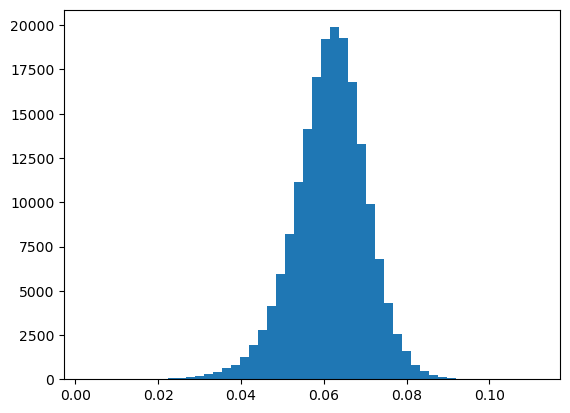

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

letter_freq_raw = pd.read_csv('../data/letter-frequencies.csv')
letter_freq = {e.letter: e.freq for _, e in letter_freq_raw.iterrows()}
inflation_scores = {word: sum(letter_freq[c] for c in word)/len(word) for word in all_words}
plt.hist(inflation_scores.values(), bins=50)
plt.show()

In [4]:
with open('results/inflated-words.txt', 'w') as f:
    inflated_words = {k: v for k, v in inflation_scores.items() if v > 0.075}
    f.write(str(len(inflated_words)))
    f.write(str(inflated_words))

### Find answers not in English

In [5]:
import wordninja
def split_words(s):
    contractions = ['d', 'm', 's', 't', 'll', 're', 've']
    split = wordninja.split(s)
    for i in range(len(split)-1, 0, -1):
        if split[i] in contractions:
            split[i-1] += split.pop(i)
    return ' '.join(split)

split_words('zees')

'zees'

In [6]:
import numpy as np

answers = np.unique(clue_processor.clues['answer'])
answers = {answer: list({answer.lower(), split_words(answer).lower()}) for answer in answers}
answers = {answer: [variant.split() for variant in variants] for answer, variants in answers.items()}
answers

{'AAA': [['aaa']],
 'AAABALL': [['aaa', 'ball'], ['aaaball']],
 'AAABATTERY': [['aaa', 'battery'], ['aaabattery']],
 'AAABONDS': [['aaa', 'bonds'], ['aaabonds']],
 'AAACARD': [['aaacard'], ['aaa', 'card']],
 'AAACARDS': [['aaa', 'cards'], ['aaacards']],
 'AAACELL': [['aaa', 'cell'], ['aaacell']],
 'AAAH': [['a', 'a', 'ah'], ['aaah']],
 'AAAL': [['a', 'a', 'al'], ['aaal']],
 'AAAMAP': [['aaamap'], ['a', 'a', 'amap']],
 'AAAMEETING': [['aaa', 'meeting'], ['aaameeting']],
 'AAAMEMBER': [['aaamember'], ['aaa', 'member']],
 'AAAMEMBERS': [['aaamembers'], ['aaa', 'members']],
 'AAAMILNE': [['aaa', 'milne'], ['aaamilne']],
 'AAAPAPER': [['aaapaper'], ['aaa', 'paper']],
 'AAARATED': [['aaarated'], ['aaa', 'rated']],
 'AAARATING': [['aaa', 'rating'], ['aaarating']],
 'AAARGH': [['aaargh'], ['a', 'a', 'argh']],
 'AAAS': [['aaas'], ['a', 'a', 'as']],
 'AAATEAM': [['aaateam'], ['aaa', 'team']],
 'AAATEAMS': [['aaa', 'teams'], ['aaateams']],
 'AAATRIPTIK': [['aaa', 'trip', 'tik'], ['aaatriptik']],


In [7]:
from nltk.corpus import words, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import re

lem = WordNetLemmatizer()
p = re.compile('^[a-zA-Z]+$')
with open(os.path.join(const.DATA_PATH, 'dwyl-words.txt'), 'r') as f:
    dwyl_words = [line.rstrip().lower() for line in f if p.match(line)]
english = set([w.lower() for w in words.words()]) | set([w.lower() for w in wordnet.words()]) | set(dwyl_words)
parts_of_speech = ['n', 'v', 'a', 'r', 's']
not_english = [
    answer for answer, variants in answers.items() if all(all(all(
        lem.lemmatize(word, pos=pos) not in english 
        for pos in parts_of_speech) 
        for word in variant) 
        for variant in variants)
]

with open('../data/english.txt', 'w') as f:
    f.write('\n'.join(english))

print(len(not_english))
with open('results/not_english.txt', 'w') as f:
    f.write('\n'.join(not_english))

0


In [28]:
reused_words = {'afan': 2, 'dopi': 2, 'cheee': 2, 'ertes': 2, 'anse': 2, 'yolo': 2, 'sentra': 2, 'aas': 3, 'irie': 2, 'asl': 2, 'ass': 4, 'ghia': 2, 'soc': 2, 'ssr': 2, 'sda': 2, 'aloes': 2, 'amst': 2, 'osee': 2, 'dna': 2, 'deb': 2, 'asr': 3, 'atwa': 2, 'osa': 2, 'cui': 2, 'elara': 2, 'ataa': 2, 'enc': 2, 'diner': 2, 'naa': 2, 'abar': 2, 'orelse': 2, 'dca': 4, 'ret': 2, 'naha': 2, 'tats': 2, 'pipecleaner': 2, 'bearsa': 2, 'alj': 2, 'able': 2, 'aeron': 2, 'celie': 2, 'nlwest': 2, 'oso': 2, 'pee': 2, 'abe': 2, 'asim': 2, 'ess': 2, 'sobe': 2, 'asi': 2, 'altercation': 2, 'sab': 2, 'ens': 2, 'deyse': 2, 'elu': 2, 'scr': 4, 'sotto': 2, 'hied': 2, 'dess': 2, 'syd': 2, 'ntro': 2, 'sixam': 2, 'eei': 2, 'ela': 2, 'alt': 2, 'ssi': 2, 'mal': 2, 'ena': 2, 'sphere': 2, 'ericathered': 2, 'abba': 2, 'hor': 2, 'sse': 5, 'ats': 2, 'eos': 2, 'ces': 2, 'sts': 2, 'dssn': 2, 'uar': 2, 'ore': 2, 'seat': 2, 'ccl': 2, 'lsdtrip': 2, 'oast': 2, 'rss': 6, 'err': 2, 'nasd': 2, 'esce': 2, 'nar': 4, 'stater': 2, 'ene': 2, 'sds': 2, 'sba': 2, 'aey': 2, 'net': 2, 'eta': 2, 'dbar': 2, 'order': 2, 'ses': 2, 'tas': 2, 'lbo': 2, 'epics': 2, 'dews': 2, 'els': 2, 'liat': 2, 'nsa': 2, 'cns': 2, 'ria': 2, 'ttest': 2, 'idcard': 2, 'arana': 3, 'tbt': 2, 'lil': 2, 'iom': 2, 'ssn': 2, 'als': 2, 'amii': 2, 'raye': 2, 'eno': 2, 'ees': 2, 'dec': 2, 'opart': 2, 'aet': 2, 'oma': 2, 'leantos': 2, 'avs': 2, 'nooil': 2, 'anal': 2, 'ada': 2, 'esa': 2, 'sras': 2, 'ser': 2, 'pmi': 2, 'sys': 2, 'serac': 2, 'elsa': 2, 'emer': 2, 'nat': 2, 'yoyos': 2, 'dss': 2, 'rmn': 2, 'aar': 2, 'sss': 2, 'cit': 2, 'aani': 2, 'sarto': 2, 'tsr': 2, 'law': 2, 'edt': 2, 'mia': 2, 'canea': 3, 'ays': 2, 'all': 2, 'dcs': 2, 'der': 2, 'bans': 2, 'atna': 2, 'cag': 2, 'asn': 2, 'oho': 2, 'ent': 3, 'asold': 2, 'nes': 2, 'ede': 2, 'edo': 2, 'byit': 2, 'enes': 2, 'srs': 2, 'noe': 2, 'gate': 2, 'nda': 2, 'esc': 2, 'sas': 2, 'flo': 2, 'otc': 2}
pd.concat([
    clue_processor.clues[clue_processor.clues.answer==w.upper()].head(1) for w in reused_words
])[['clue', 'answer']].to_string()

'                                                                                           clue       answer\n172879                                                                   I\'m ___ from way back!         AFAN\n1156606                                                                      Tech debut of 2001         DOPI\n910005                                                                           Burger topping        CHEEE\n9792                                                                 Romain de Tirtoff artworks        ERTES\n493811                                                               "As I Lay Dying" character         ANSE\n577                                                Acronym shouted while jumping out of a plane         YOLO\n25237                                                                              Nissan sedan       SENTRA\n26554                                                                           Small batteries          AAS\n85062   

In [30]:
[answers[word.upper()] for word in reused_words]

[[['afan'], ['a', 'fan']],
 [['dopi'], ['do', 'pi']],
 [['chee', 'e'], ['cheee']],
 [['er', 'tes'], ['ertes']],
 [['anse']],
 [['yo', 'lo'], ['yolo']],
 [['sent', 'ra'], ['sentra']],
 [['a', 'as'], ['aas']],
 [['i', 'rie'], ['irie']],
 [['asl']],
 [['as', 's'], ['ass']],
 [['ghia'], ['g', 'hi', 'a']],
 [['soc']],
 [['ssr']],
 [['sda']],
 [['aloes']],
 [['amst'], ['a', 'mst']],
 [['osee'], ['o', 'see']],
 [['dna']],
 [['deb']],
 [['as', 'r'], ['asr']],
 [['atwa'], ['a', 'twa']],
 [['osa']],
 [['cui']],
 [['elara']],
 [['at', 'a', 'a'], ['ataa']],
 [['enc']],
 [['diner']],
 [['na', 'a'], ['naa']],
 [['abar'], ['a', 'bar']],
 [['orelse'], ['or', 'else']],
 [['dc', 'a'], ['dca']],
 [['ret']],
 [['naha']],
 [['tats']],
 [['pipecleaner'], ['pipe', 'cleaner']],
 [['bearsa'], ['bears', 'a']],
 [['alj'], ['al', 'j']],
 [['able']],
 [['aeron']],
 [['c', 'elie'], ['celie']],
 [['nl', 'west'], ['nlwest']],
 [['oso']],
 [['pee']],
 [['abe'], ['a', 'be']],
 [['asim'], ['a', 'sim']],
 [['ess']],
 [['